# Machine Learning Model to predict whether the claim is approved or denied

In [1]:
# Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import joblib

# Load data
df = pd.read_csv("medical_claims_dataset.csv")

# Drop unused columns
df.drop(columns=['claim_id', 'patient_id', 'provider_id', 'service_date', 'claim_submission_date'], inplace=True)

# Encode target
label_encoders = {}
target_col = 'claim_status'
df[target_col] = df[target_col].astype(str)
le_status = LabelEncoder()
df[target_col] = le_status.fit_transform(df[target_col])
label_encoders[target_col] = le_status

# Encode features
for col in df.select_dtypes(include='object').columns:
    if col != target_col:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le
        
# Features and target
X = df.drop(columns=['claim_status', 'denial_reason', 'denial_category', 'is_denied'])
y = df['claim_status']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# SMOTE
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)


# Models to try
models = {
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}


# Train and evaluate
results = []
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=le_status.classes_, output_dict=True)
    results.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        "Precision": round(report["weighted avg"]["precision"], 4),
        "Recall": round(report["weighted avg"]["recall"], 4),
        "F1-Score": round(report["weighted avg"]["f1-score"], 4)
    })
    

# Show result
results_df = pd.DataFrame(results)
print(results_df)




C:\Users\louky\anaconda3.loukya\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:54:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


                 Model  Accuracy  Precision  Recall  F1-Score
0        Random Forest    0.6575     0.6759  0.6575    0.6662
1  Logistic Regression    0.5490     0.6832  0.5490    0.5930
2        Decision Tree    0.6100     0.6836  0.6100    0.6396
3              XGBoost    0.6485     0.6708  0.6485    0.6590


In [13]:
# Train and evaluate
results = []
best_f1 = 0
best_model_name = None
best_model = None

for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=le_status.classes_, output_dict=True)
    f1 = round(report["weighted avg"]["f1-score"], 4)
    
    results.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        "Precision": round(report["weighted avg"]["precision"], 4),
        "Recall": round(report["weighted avg"]["recall"], 4),
        "F1-Score": f1
    })
    
    # Check for best model
    if f1 > best_f1:
        best_f1 = f1
        best_model_name = name
        best_model = model


# Save the best model
joblib.dump(best_model, "claim_status_model.pkl")
print(f"✅ Best model is: {best_model_name} with F1-Score: {best_f1}")
print("✅ Model saved as claim_status_model.pkl")

# Save encoders
joblib.dump(label_encoders, "label_encoders_status.pkl")
joblib.dump(le_status, "claim_status_encoder.pkl")

# Show results table
results_df = pd.DataFrame(results)



C:\Users\louky\anaconda3.loukya\Lib\site-packages\xgboost\core.py:158: UserWarning: [05:56:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Best model is: Random Forest with F1-Score: 0.6662
✅ Model saved as claim_status_model.pkl


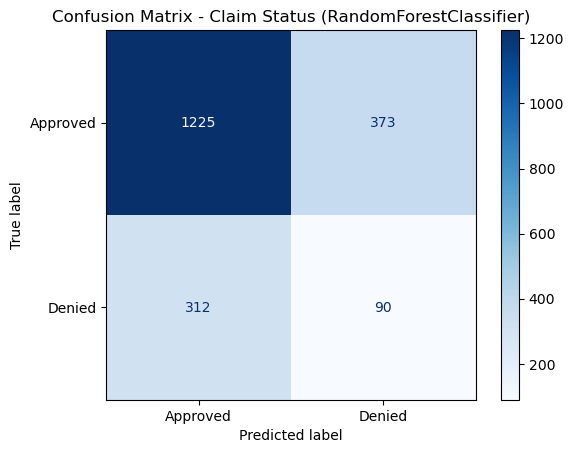

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Now this will be a (2, 2) matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le_status.classes_)
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix - Claim Status ({type(best_model).__name__})")
plt.show()


In [7]:
from sklearn.metrics import classification_report

# Get predictions again if needed
y_pred = best_model.predict(X_test)

# Generate detailed classification report
report = classification_report(y_test, y_pred, target_names=le_status.classes_, output_dict=True)

# Convert to DataFrame for nicer display
report_df = pd.DataFrame(report).transpose()

# Round and clean up
report_df = report_df[['precision', 'recall', 'f1-score', 'support']].round(3)
display(report_df)


,precision,recall,f1-score,support
Approved,0.797,0.767,0.781,1598.000
Denied,0.194,0.224,0.208,402.000
accuracy,0.658,0.658,0.658,0.658
macro avg,0.496,0.495,0.495,2000.000
weighted avg,0.676,0.658,0.666,2000.000


# Machine Learning model to predict denial reason


In [2]:
# Step 1: Filter only denied claims with known reasons
df_denied = df[(df['is_denied'] == 1) & (df['denial_reason'].notnull())].copy()

# Step 2: Encode the denial reason
from sklearn.preprocessing import LabelEncoder
le_reason = LabelEncoder()
df_denied['denial_reason'] = le_reason.fit_transform(df_denied['denial_reason'])

# Step 3: Features and target for denied claims
X_reason = df_denied[X.columns]  # reuse the same features
y_reason = df_denied['denial_reason']

# Step 4: Split data
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reason, y_reason, test_size=0.2, random_state=42)

# Step 5: Train models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

models_reason = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

results_reason = []
for name, model in models_reason.items():
    model.fit(Xr_train, yr_train)
    yr_pred = model.predict(Xr_test)
    acc = accuracy_score(yr_test, yr_pred)
    report = classification_report(yr_test, yr_pred, output_dict=True)
    results_reason.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        "Precision": round(report["weighted avg"]["precision"], 4),
        "Recall": round(report["weighted avg"]["recall"], 4),
        "F1-Score": round(report["weighted avg"]["f1-score"], 4)
    })
    

# Show results
pd.DataFrame(results_reason)


C:\Users\louky\anaconda3.loukya\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\louky\anaconda3.loukya\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\louky\anaconda3.loukya\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being se

,Model,Accuracy,Precision,Recall,F1-Score
0,Decision Tree,0.0844,0.0898,0.0844,0.0868
1,Random Forest,0.1439,0.0999,0.1439,0.1111
2,Logistic Regression,0.2333,0.0671,0.2333,0.0948
3,XGBoost,0.1241,0.0943,0.1241,0.1045


In [ ]:
# Step 1: Map encoded denial_reason back to original text
reverse_map = {i: cls for i, cls in enumerate(le_reason.classes_)}
df_denied['denial_reason_text'] = df_denied['denial_reason'].map(reverse_map)

# Step 2: Get top 5 most frequent denial reasons
top_5 = df_denied['denial_reason_text'].value_counts().nlargest(5).index

# Step 3: Group rare ones as 'Other'
df_denied['denial_reason_grouped'] = df_denied['denial_reason_text'].apply(lambda x: x if x in top_5 else 'Other')

# Step 4: Encode grouped labels
from sklearn.preprocessing import LabelEncoder
le_reason_grouped = LabelEncoder()
df_denied['denial_reason_grouped'] = le_reason_grouped.fit_transform(df_denied['denial_reason_grouped'].astype(str))

# Step 5: Split and retrain
X_reason = df_denied[X.columns]
y_reason = df_denied['denial_reason_grouped']
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reason, y_reason, test_size=0.2, random_state=42)

# Step 6: Train models
models_reason = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

results_reason_grouped = []
for name, model in models_reason.items():
    model.fit(Xr_train, yr_train)
    yr_pred = model.predict(Xr_test)
    acc = accuracy_score(yr_test, yr_pred)
    report = classification_report(yr_test, yr_pred, output_dict=True)
    results_reason_grouped.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        "Precision": round(report["weighted avg"]["precision"], 4),
        "Recall": round(report["weighted avg"]["recall"], 4),
        "F1-Score": round(report["weighted avg"]["f1-score"], 4)
    })
    

# Show results
pd.DataFrame(results_reason_grouped)


C:\Users\louky\anaconda3.loukya\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\louky\anaconda3.loukya\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\louky\anaconda3.loukya\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being se

,Model,Accuracy,Precision,Recall,F1-Score
0,Decision Tree,0.2382,0.2582,0.2382,0.2471
1,Random Forest,0.3548,0.2447,0.3548,0.2676
2,Logistic Regression,0.4144,0.1717,0.4144,0.2428
3,XGBoost,0.3251,0.2570,0.3251,0.2794


In [16]:
# Define models
models_reason = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

# Train and select best
results_reason = []
best_f1 = 0
best_model_name = None
best_model = None

for name, model in models_reason.items():
    model.fit(Xr_train, yr_train)
    yr_pred = model.predict(Xr_test)
    acc = accuracy_score(yr_test, yr_pred)
    report = classification_report(yr_test, yr_pred, output_dict=True)
    f1 = round(report["weighted avg"]["f1-score"], 4)

    results_reason.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        "Precision": round(report["weighted avg"]["precision"], 4),
        "Recall": round(report["weighted avg"]["recall"], 4),
        "F1-Score": f1
    })

    if f1 > best_f1:
        best_f1 = f1
        best_model = model
        best_model_name = name

# Save the best model and encoder
joblib.dump(best_model, "denial_reason_model_grouped.pkl")
joblib.dump(le_reason_grouped, "denial_reason_encoder_grouped.pkl")

# Output result
print(f"✅ Best denial reason model: {best_model_name} with F1-Score: {best_f1}")
pd.DataFrame(results_reason)


C:\Users\louky\anaconda3.loukya\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\louky\anaconda3.loukya\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\louky\anaconda3.loukya\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being se

✅ Best denial reason model: XGBoost with F1-Score: 0.2794


,Model,Accuracy,Precision,Recall,F1-Score
0,Decision Tree,0.2382,0.2582,0.2382,0.2471
1,Random Forest,0.3548,0.2447,0.3548,0.2676
2,Logistic Regression,0.4144,0.1717,0.4144,0.2428
3,XGBoost,0.3251,0.2570,0.3251,0.2794


In [17]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Load main dataset
df = pd.read_csv("medical_claims_dataset.csv")

# Filter denied claims
df_denied = df[df['claim_status'] == 'Denied'].copy()

# Drop unused columns
drop_cols = ['claim_id', 'patient_id', 'provider_id', 'service_date', 'claim_submission_date']
df_denied.drop(columns=drop_cols, inplace=True, errors='ignore')

# Encode features
label_encoders = {}
for col in df_denied.select_dtypes(include='object').columns:
    if col not in ['claim_status', 'denial_reason', 'denial_category']:
        le = LabelEncoder()
        df_denied[col] = le.fit_transform(df_denied[col].astype(str))
        label_encoders[col] = le

# Step 1: Convert encoded denial reason back to text (if needed)
# If denial_reason is already text, skip this step
df_denied['denial_reason_text'] = df_denied['denial_reason'].astype(str)

# Step 2: Get top 5 most common reasons
top_5 = df_denied['denial_reason_text'].value_counts().nlargest(5).index

# Step 3: Group rare reasons under 'Other'
df_denied['denial_reason_grouped'] = df_denied['denial_reason_text'].apply(lambda x: x if x in top_5 else 'Other')

# Step 4: Encode grouped text labels
le_reason_grouped = LabelEncoder()
df_denied['denial_reason_grouped_encoded'] = le_reason_grouped.fit_transform(df_denied['denial_reason_grouped'])

# ✅ Save the correct text-label encoder
joblib.dump(le_reason_grouped, "denial_reason_encoder_grouped.pkl")

# Step 5: Prepare features and target
X_reason = df_denied.drop(columns=['claim_status', 'denial_reason', 'denial_category', 'denial_reason_text', 'denial_reason_grouped', 'denial_reason_grouped_encoded'])
y_reason = df_denied['denial_reason_grouped_encoded']

# Step 6: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_reason, y_reason, test_size=0.2, random_state=42)

# Step 7: Train model (best one)
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
model.fit(X_train, y_train)

# Step 8: Evaluate
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=le_reason_grouped.classes_)
print(report)

# ✅ Save model and label encoders
joblib.dump(model, "denial_reason_model_grouped.pkl")
joblib.dump(label_encoders, "denial_reason_label_encoders.pkl")


C:\Users\louky\anaconda3.loukya\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:33:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


                                   precision    recall  f1-score   support

       Duplicate Claim Submission       0.13      0.05      0.08        37
 Eligibility Verification Failure       0.04      0.02      0.03        47
Inadequate Clinical Documentation       0.06      0.03      0.04        31
     Incomplete Registration Data       0.26      0.22      0.24        96
        Incorrect Procedure Codes       0.00      0.00      0.00        25
                            Other       0.42      0.63      0.50       167

                         accuracy                           0.33       403
                        macro avg       0.15      0.16      0.15       403
                     weighted avg       0.26      0.33      0.28       403



['denial_reason_label_encoders.pkl']